In [ ]:
# Dataset link - https://www.kaggle.com/datasets/subhamjain/loan-prediction-based-on-customer-behavior

In [1]:
# util library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# preprocessors
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#oversampling
from imblearn.over_sampling import SMOTE

#model trainig
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

#model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, balanced_accuracy_score

warnings.filterwarnings('ignore')  

In [2]:
df = pd.read_csv('Training Data.csv')
df

Id   Income  Age  Experience Married/Single House_Ownership  \
0            1  1303834   23           3         single          rented   
1            2  7574516   40          10         single          rented   
2            3  3991815   66           4        married          rented   
3            4  6256451   41           2         single          rented   
4            5  5768871   47          11         single          rented   
...        ...      ...  ...         ...            ...             ...   
251995  251996  8154883   43          13         single          rented   
251996  251997  2843572   26          10         single          rented   
251997  251998  4522448   46           7         single          rented   
251998  251999  6507128   45           0         single          rented   
251999  252000  9070230   70          17         single          rented   

       Car_Ownership           Profession                 CITY  \
0                 no  Mechanical_engineer                 Rewa   
1                 no   Software_Developer             Parbhani   
2                 no     Technical_writer            Alappuzha   
3                yes   Software_Developer          Bhubaneswar   
4                 no        Civil_servant  Tiruchirappalli[10]   
...              ...                  ...                  ...   
251995            no              Surgeon              Kolkata   
251996            no         Army_officer                 Rewa   
251997            no      Design_Engineer      Kalyan-Dombivli   
251998            no     Graphic_Designer          Pondicherry   
251999            no         Statistician                Avadi   

                 STATE  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
0       Madhya_Pradesh                3                 13          0  
1          Maharashtra                9                 13          0  
2               Kerala                4                 10          0  
3               Odisha                2                 12          1  
4           Tamil_Nadu                3                 14          1  
...                ...              ...                ...        ...  
251995     West_Bengal                6                 11          0  
251996  Madhya_Pradesh                6                 11          0  
251997     Maharashtra                7                 12          0  
251998      Puducherry                0                 10          0  
251999      Tamil_Nadu                7                 11          0  

[252000 rows x 13 columns]

In [3]:
# Checking Null values
df.isnull().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

In [4]:
# Checking dtype of every column
df.dtypes

Id                    int64
Income                int64
Age                   int64
Experience            int64
Married/Single       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object

In [5]:
df.duplicated().value_counts()

False    252000
dtype: int64

In [6]:
df.shape

(252000, 13)

#  EDA

In [7]:
sns.countplot(x='Risk_Flag',data=df)
df['Risk_Flag'].value_counts()

0    221004
1     30996
Name: Risk_Flag, dtype: int64

## Observation - 
There were around 31000 people out of 252000 who was not able to pay the loan.

The data is highly Imbalanced - will do something in feature engineering

# Numerical Variables

In [8]:
numerical_features = df.select_dtypes(exclude='O').columns
numerical_features

Index(['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS',
       'CURRENT_HOUSE_YRS', 'Risk_Flag'],
      dtype='object')

# Discrete Variables

In [9]:
discrete_features = [features for features in numerical_features if len(df[features].unique())<=5]
discrete_features

['CURRENT_HOUSE_YRS', 'Risk_Flag']

In [10]:
for features in discrete_features:
    if features != 'Risk_Flag':
        sns.countplot(x = 'Risk_Flag',hue = features,data = df , palette='terrain_r')
        plt.title(features)
        plt.legend(loc='right')
        plt.show()

## Observation - 
People of every year have not paid the loan at same level as we can see in 1

In [11]:
continous_feature = [features for features in numerical_features if features not in discrete_features]
continous_feature

['Id', 'Income', 'Age', 'Experience', 'CURRENT_JOB_YRS']

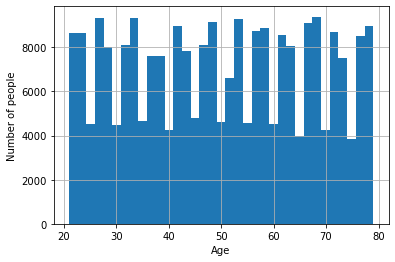

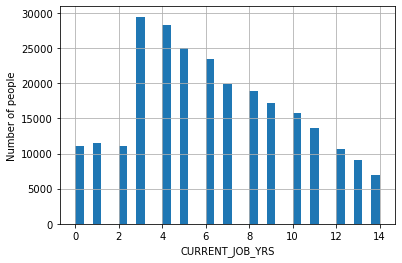

In [12]:
for features in continous_feature:
    if features != 'Id':
        df[features].hist(bins=35)
        plt.xlabel(features)
        plt.ylabel('Number of people')
        plt.show()

## Observation
More people have experience of 3 years in their current job

# Categorical Variables

In [13]:
categorical_features = df.select_dtypes(include='O').columns
categorical_features

Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE'],
      dtype='object')

Married/Single  Risk_Flag
married         0             23092
                1              2636
single          0            197912
                1             28360
Name: Risk_Flag, dtype: int64


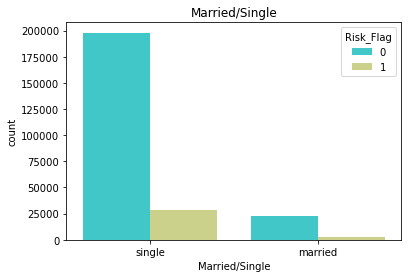

House_Ownership  Risk_Flag
norent_noown     0              6469
                 1               715
owned            0             11758
                 1              1160
rented           0            202777
                 1             29121
Name: Risk_Flag, dtype: int64


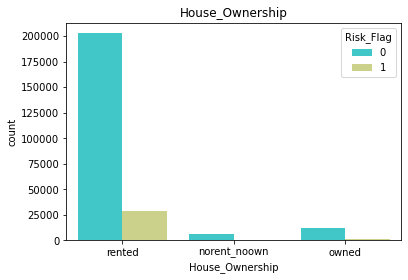

Car_Ownership  Risk_Flag
no             0            153439
               1             22561
yes            0             67565
               1              8435
Name: Risk_Flag, dtype: int64


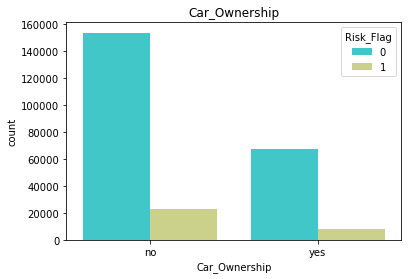

In [14]:
for features in categorical_features:
    if features not in 'Profession'+'STATE'+'CITY':
        print(df.groupby(features)['Risk_Flag'].value_counts())
        sns.countplot(x=features,hue='Risk_Flag',data=df,palette='rainbow')
        plt.title(features)
        plt.show()

## Observation
1. More single people have not paid the loan
2. More people who lives on rent have not paid the loan
3. More people without cars have not paid the loan



## Top 10 professions who had not paid the loan

In [15]:
df.groupby(['Profession'])['Risk_Flag'].value_counts().sort_values(ascending=False).iloc[:10]

Profession                  Risk_Flag
Physician                   0            5247
Statistician                0            5135
Web_designer                0            4808
Drafter                     0            4754
Psychologist                0            4733
Industrial_Engineer         0            4732
Magistrate                  0            4714
Fashion_Designer            0            4692
Computer_hardware_engineer  0            4682
Mechanical_engineer         0            4635
Name: Risk_Flag, dtype: int64

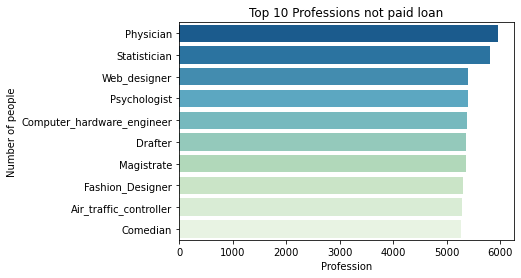

In [16]:
sns.countplot(y=df['Profession'],order=df['Profession'].value_counts().iloc[:10].index,palette='GnBu_r')
plt.title('Top 10 Professions not paid loan')
plt.xlabel('Profession')
plt.ylabel('Number of people')
plt.show()

## Top 10 State from which people have not paid the loan

In [17]:
df.groupby('STATE')['Risk_Flag'].value_counts().sort_values(ascending=False).iloc[0:10]

STATE           Risk_Flag
Uttar_Pradesh   0            25057
Maharashtra     0            22667
Andhra_Pradesh  0            22362
West_Bengal     0            20474
Bihar           0            17197
Tamil_Nadu      0            14831
Madhya_Pradesh  0            11942
Karnataka       0            10666
Gujarat         0            10065
Rajasthan       0             7882
Name: Risk_Flag, dtype: int64

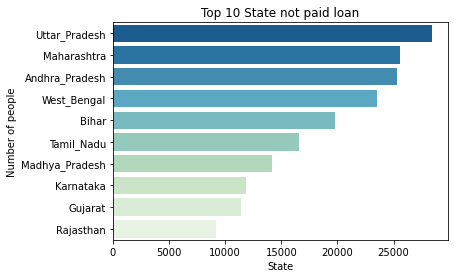

In [18]:
sns.countplot(y=df['STATE'],order=df['STATE'].value_counts().iloc[:10].index,palette='GnBu_r')
plt.title('Top 10 State not paid loan')
plt.xlabel('State')
plt.ylabel('Number of people')
plt.show()

## Top 10 City from which people have not paid the loan

In [19]:
df.groupby('CITY')['Risk_Flag'].value_counts().sort_values(ascending=False).iloc[0:10]

CITY           Risk_Flag
Vijayanagaram  0            1110
Saharsa[29]    0            1067
Bulandshahr    0            1061
Bhopal         0            1042
Vijayawada     0            1025
New_Delhi      0            1024
Bellary        0             992
Satara         0             992
Bareilly       0             992
Jodhpur        0             974
Name: Risk_Flag, dtype: int64

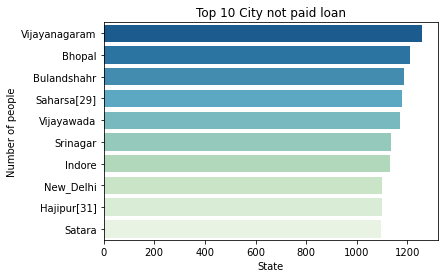

In [20]:
sns.countplot(y=df['CITY'],order=df['CITY'].value_counts().iloc[:10].index,palette='GnBu_r')
plt.title('Top 10 City not paid loan')
plt.xlabel('State')
plt.ylabel('Number of people')
plt.show()

In [21]:
categorical_features

Index(['Married/Single', 'House_Ownership', 'Car_Ownership', 'Profession',
       'CITY', 'STATE'],
      dtype='object')

# Feature Engineering

In [22]:
# Dropping some columns because they will not help in predicting the Price

df.drop(columns=['Id','CITY','STATE'],inplace=True)

In [23]:
df

Income  Age  Experience Married/Single House_Ownership Car_Ownership  \
0       1303834   23           3         single          rented            no   
1       7574516   40          10         single          rented            no   
2       3991815   66           4        married          rented            no   
3       6256451   41           2         single          rented           yes   
4       5768871   47          11         single          rented            no   
...         ...  ...         ...            ...             ...           ...   
251995  8154883   43          13         single          rented            no   
251996  2843572   26          10         single          rented            no   
251997  4522448   46           7         single          rented            no   
251998  6507128   45           0         single          rented            no   
251999  9070230   70          17         single          rented            no   

                 Profession  CURRENT_JOB_YRS  CURRENT_HOUSE_YRS  Risk_Flag  
0       Mechanical_engineer                3                 13          0  
1        Software_Developer                9                 13          0  
2          Technical_writer                4                 10          0  
3        Software_Developer                2                 12          1  
4             Civil_servant                3                 14          1  
...                     ...              ...                ...        ...  
251995              Surgeon                6                 11          0  
251996         Army_officer                6                 11          0  
251997      Design_Engineer                7                 12          0  
251998     Graphic_Designer                0                 10          0  
251999         Statistician                7                 11          0  

[252000 rows x 10 columns]

### Performing One hot encoding on Married/Single, House Ownership and Car_Ownership 

In [24]:
cols = ['Married/Single','House_Ownership','Car_Ownership']
for col in cols:
    dummy = pd.get_dummies(df[col],drop_first=True)
    df = pd.concat([df,dummy],axis=1)
    df.drop(columns=[col],inplace=True)

In [25]:
df

Income  Age  Experience           Profession  CURRENT_JOB_YRS  \
0       1303834   23           3  Mechanical_engineer                3   
1       7574516   40          10   Software_Developer                9   
2       3991815   66           4     Technical_writer                4   
3       6256451   41           2   Software_Developer                2   
4       5768871   47          11        Civil_servant                3   
...         ...  ...         ...                  ...              ...   
251995  8154883   43          13              Surgeon                6   
251996  2843572   26          10         Army_officer                6   
251997  4522448   46           7      Design_Engineer                7   
251998  6507128   45           0     Graphic_Designer                0   
251999  9070230   70          17         Statistician                7   

        CURRENT_HOUSE_YRS  Risk_Flag  single  owned  rented  yes  
0                      13          0       1      0       1    0  
1                      13          0       1      0       1    0  
2                      10          0       0      0       1    0  
3                      12          1       1      0       1    1  
4                      14          1       1      0       1    0  
...                   ...        ...     ...    ...     ...  ...  
251995                 11          0       1      0       1    0  
251996                 11          0       1      0       1    0  
251997                 12          0       1      0       1    0  
251998                 10          0       1      0       1    0  
251999                 11          0       1      0       1    0  

[252000 rows x 11 columns]

In [26]:
df['Profession'] = LabelEncoder().fit_transform(df['Profession'])

In [27]:
df

Income  Age  Experience  Profession  CURRENT_JOB_YRS  \
0       1303834   23           3          33                3   
1       7574516   40          10          43                9   
2       3991815   66           4          47                4   
3       6256451   41           2          43                2   
4       5768871   47          11          11                3   
...         ...  ...         ...         ...              ...   
251995  8154883   43          13          45                6   
251996  2843572   26          10           3                6   
251997  4522448   46           7          17                7   
251998  6507128   45           0          27                0   
251999  9070230   70          17          44                7   

        CURRENT_HOUSE_YRS  Risk_Flag  single  owned  rented  yes  
0                      13          0       1      0       1    0  
1                      13          0       1      0       1    0  
2                      10          0       0      0       1    0  
3                      12          1       1      0       1    1  
4                      14          1       1      0       1    0  
...                   ...        ...     ...    ...     ...  ...  
251995                 11          0       1      0       1    0  
251996                 11          0       1      0       1    0  
251997                 12          0       1      0       1    0  
251998                 10          0       1      0       1    0  
251999                 11          0       1      0       1    0  

[252000 rows x 11 columns]

In [28]:
X = df.drop('Risk_Flag',axis=1)
y = df['Risk_Flag']

In [29]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

## Most important feature

<AxesSubplot:>

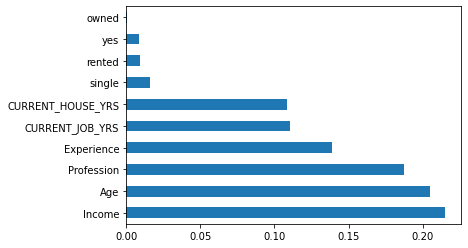

In [30]:
imp_feature = ExtraTreeClassifier()
imp_feature.fit(X,y)
feature_imp = pd.Series(imp_feature.feature_importances_,index=X.columns)
feature_imp.nlargest(10).plot.barh()

### In EDA we have seen that the data is imbalanced. So let's do oversampling

In [31]:
X_scaled, y = SMOTE().fit_resample(X_scaled, y)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.30, random_state = np.random.randint(100))

In [33]:
model = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [34]:
# cv = StratifiedShuffleSplit(n_splits = 10, test_size = 0.4, random_state = 0 )
# model_cv = RandomizedSearchCV(estimator=model,param_distributions=random_grid,scoring='accuracy',cv=cv,random_state = 42,n_iter=10)

# model_cv.fit(X_train,y_train)

In [35]:
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [36]:
accuracy_score(y_test,y_pred)

0.9407705708015656

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94     66340
           1       0.91      0.98      0.94     66263

    accuracy                           0.94    132603
   macro avg       0.94      0.94      0.94    132603
weighted avg       0.94      0.94      0.94    132603



In [38]:
import pickle 
pickle.dump(model,open('model.pkl','wb'))

In [39]:
X

Income  Age  Experience  Profession  CURRENT_JOB_YRS  \
0       1303834   23           3          33                3   
1       7574516   40          10          43                9   
2       3991815   66           4          47                4   
3       6256451   41           2          43                2   
4       5768871   47          11          11                3   
...         ...  ...         ...         ...              ...   
251995  8154883   43          13          45                6   
251996  2843572   26          10           3                6   
251997  4522448   46           7          17                7   
251998  6507128   45           0          27                0   
251999  9070230   70          17          44                7   

        CURRENT_HOUSE_YRS  single  owned  rented  yes  
0                      13       1      0       1    0  
1                      13       1      0       1    0  
2                      10       0      0       1    0  
3                      12       1      0       1    1  
4                      14       1      0       1    0  
...                   ...     ...    ...     ...  ...  
251995                 11       1      0       1    0  
251996                 11       1      0       1    0  
251997                 12       1      0       1    0  
251998                 10       1      0       1    0  
251999                 11       1      0       1    0  

[252000 rows x 10 columns]